In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 50)
import geopandas as gpd
import numpy as np
import math

In [2]:
# data gathered on 19th of Feb, 2021
INFO_PATH = "../data/country_info.csv"  # https://www.kaggle.com/koryto/countryinfo?select=covid19countryinfo.csv
VACCINATION_PATH = "../data/country_vaccinations.csv"  # https://www.kaggle.com/gpreda/covid-world-vaccination-progress
SHAPEFILE_PATH = "../shapefiles/ne_10m_admin_0_countries_lakes/ne_10m_admin_0_countries_lakes.shp"  # https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/cultural/ne_10m_admin_0_countries_lakes.zip

In [3]:
colors = 100
cmap = 'Blues'
figsize = (16, 10)
month_year = "02/2021"
cols = []
title = f"COVID-19 Vaccination on {month_year}"
imgfile = f"../out/images/img_{title}.png"
description = "If vaccination across various countries remain in the same pace(as of 19th of Feb, 2021), thats how the " \
              "race goes. " \
              "Data: Our World in Data - ourworldindata.org • Author: Gabriel Tardochi Salles".strip()

In [4]:
geo_df = gpd.read_file(SHAPEFILE_PATH)[['ADM0_A3', 'geometry']].to_crs('+proj=robin')
info_df = pd.read_csv(INFO_PATH, usecols=["country", "alpha3code", "pop"])
info_df = info_df[(~info_df['alpha3code'].isna()) & (~info_df['pop'].isna())]
info_df['pop'] = info_df['pop'].str.replace(",", "").astype(int)
vac_df = pd.read_csv(VACCINATION_PATH, usecols=["country", "iso_code", "date", "total_vaccinations","daily_vaccinations"], parse_dates=["date"])
vac_df = vac_df[~vac_df['iso_code'].isna()]

In [5]:
vac_df = vac_df[vac_df['iso_code'].isin(info_df['alpha3code'].tolist())]
vac_df.tail()

,country,iso_code,date,total_vaccinations,daily_vaccinations
3325,United States,USA,2021-02-13,50641884.0,1657703.0
3326,United States,USA,2021-02-14,52884356.0,1667631.0
3327,United States,USA,2021-02-15,NaN,1662106.0
3328,United States,USA,2021-02-16,55220364.0,1716311.0
3329,United States,USA,2021-02-17,56281827.0,1644551.0


In [6]:
all_countries = vac_df[vac_df['daily_vaccinations'].isna() == False].country.unique().tolist()
good_confidence_countries = []
countries_daily_fforward = {}
countries_first_update = {}
countries_latest_update = {}

for c in all_countries:
    first_non_na_i = vac_df[(vac_df['daily_vaccinations'].isna() == False) & (vac_df['country'] == c)].head(1).index.item()
    this_c_df = vac_df[(vac_df.index >= first_non_na_i) & (vac_df.country == c)]
    nans_after_first_nan = this_c_df.daily_vaccinations.isna().sum()
    days_with_info = this_c_df.daily_vaccinations.notna().sum()
    first_non_nan_update = this_c_df[this_c_df.daily_vaccinations.notna()]['date'].head(1).item()
    latest_non_nan_update = this_c_df[this_c_df.daily_vaccinations.notna()]['date'].tail(1).item()
    lastest_date = this_c_df['date'].tail(1).item()
    if days_with_info < 15:
        continue
    else:
        good_confidence_countries.append(c)
        print(f"{c}: nans after first non nan: {nans_after_first_nan}, number of days with info: {days_with_info}, first and last update: {first_non_nan_update} & {latest_non_nan_update}")
        all_time_mean = this_c_df[this_c_df.daily_vaccinations.notna()]['daily_vaccinations'].mean()
        recent_mean = this_c_df[this_c_df.daily_vaccinations.notna()]['daily_vaccinations'].tail(5).mean()
        selected_forward_daily_vac = math.floor(0.15 * all_time_mean + recent_mean * 0.85)
        countries_daily_fforward[c] = selected_forward_daily_vac
        countries_first_update[c] = first_non_nan_update
        countries_latest_update[c] = latest_non_nan_update
        
vac_df = vac_df[vac_df['country'].isin(good_confidence_countries)]

Albania: nans after first non nan: 6, number of days with info: 32, first and last update: 2021-01-11 00:00:00 & 2021-02-17 00:00:00
Andorra: nans after first non nan: 0, number of days with info: 18, first and last update: 2021-01-26 00:00:00 & 2021-02-12 00:00:00
Argentina: nans after first non nan: 0, number of days with info: 50, first and last update: 2020-12-30 00:00:00 & 2021-02-17 00:00:00
Austria: nans after first non nan: 0, number of days with info: 35, first and last update: 2021-01-14 00:00:00 & 2021-02-17 00:00:00
Azerbaijan: nans after first non nan: 0, number of days with info: 20, first and last update: 2021-01-18 00:00:00 & 2021-02-06 00:00:00
Bahrain: nans after first non nan: 0, number of days with info: 56, first and last update: 2020-12-24 00:00:00 & 2021-02-17 00:00:00
Bangladesh: nans after first non nan: 0, number of days with info: 22, first and last update: 2021-01-27 00:00:00 & 2021-02-17 00:00:00
Belgium: nans after first non nan: 0, number of days with inf

In [7]:
vac_df[vac_df['date'] == vac_df[vac_df.daily_vaccinations.notna()]['date'].min()]

,country,iso_code,date,total_vaccinations,daily_vaccinations
3205,United Kingdom,GBR,2020-12-14,NaN,83940.0


In [8]:
def create_country_date_df(countries, start, end):
    all_dfs = []
    for country in countries:
        df = pd.DataFrame({"date": pd.date_range(start, end), "country": country})
        all_dfs.append(df)
    concat_df = pd.concat(all_dfs, ignore_index=True)
    return concat_df

In [9]:
clean_df =  create_country_date_df(good_confidence_countries, '2020-12-14', '2022-12-31')

In [10]:
clean_df.loc[745:,:].head()

,date,country
745,2022-12-29,Albania
746,2022-12-30,Albania
747,2022-12-31,Albania
748,2020-12-14,Andorra
749,2020-12-15,Andorra


In [11]:
clean_df = pd.merge(left=clean_df, right=vac_df, how='left', on=['date','country'])

In [12]:
clean_df["iso_code"] = clean_df.groupby("country").transform(lambda x: x.fillna(method="bfill"))["iso_code"]
clean_df["iso_code"] = clean_df.groupby("country").transform(lambda x: x.fillna(method="ffill"))["iso_code"]
clean_df.loc[745:,:].head()

,date,country,iso_code,total_vaccinations,daily_vaccinations
745,2022-12-29,Albania,ALB,NaN,NaN
746,2022-12-30,Albania,ALB,NaN,NaN
747,2022-12-31,Albania,ALB,NaN,NaN
748,2020-12-14,Andorra,AND,NaN,NaN
749,2020-12-15,Andorra,AND,NaN,NaN


In [13]:
clean_df = clean_df.merge(info_df[["alpha3code", "pop"]], how="left", left_on="iso_code", right_on="alpha3code").drop(['alpha3code'], axis=1).rename({"pop":"needed_vaccines"}, axis=1)
clean_df['needed_vaccines'] = clean_df['needed_vaccines'] * 2

In [14]:
def correct_daily_vac_col(x):
    dt = x['date']
    country = x['country']
    before_first_info = dt < countries_first_update[country]
    after_last_info = dt > countries_latest_update[country]
    if before_first_info:
        return 0
    elif after_last_info:
        return countries_daily_fforward[country]
    elif pd.isnull(x['daily_vaccinations']):
        return x['daily_vaccinations']
    else:
        return math.floor(x['daily_vaccinations'])
clean_df['daily_vaccinations'] = clean_df.apply(lambda x: correct_daily_vac_col(x), axis=1)
clean_df['daily_vaccinations'] = clean_df['daily_vaccinations'].fillna(method="ffill")

In [15]:
clean_df[(clean_df['country'] == "Albania") & (clean_df['date'] > '2021-01-09') & (clean_df['date'] < '2021-02-20')]

,date,country,iso_code,total_vaccinations,daily_vaccinations,needed_vaccines
27,2021-01-10,Albania,ALB,0.0,0.0,5755594
28,2021-01-11,Albania,ALB,NaN,64.0,5755594
29,2021-01-12,Albania,ALB,128.0,64.0,5755594
30,2021-01-13,Albania,ALB,188.0,63.0,5755594
31,2021-01-14,Albania,ALB,266.0,66.0,5755594
32,2021-01-15,Albania,ALB,308.0,62.0,5755594
33,2021-01-16,Albania,ALB,369.0,62.0,5755594
34,2021-01-17,Albania,ALB,405.0,58.0,5755594
35,2021-01-18,Albania,ALB,447.0,55.0,5755594
36,2021-01-19,Albania,ALB,483.0,51.0,5755594


In [16]:
clean_df["total_vaccinations"] = clean_df.groupby(['country'])['daily_vaccinations'].cumsum(axis=0)

In [17]:
clean_df["imunization_coverage"] = np.where((clean_df.total_vaccinations / clean_df.needed_vaccines) < 1, (clean_df.total_vaccinations / clean_df.needed_vaccines), 1)

In [18]:
geo_df.head()

,ADM0_A3,geometry
0,IDN,"MULTIPOLYGON (((11108970.260 445285.130, 11108..."
1,MYS,"MULTIPOLYGON (((11108970.260 445285.130, 11108..."
2,CHL,"MULTIPOLYGON (((-6477059.899 -1872360.838, -64..."
3,BOL,"POLYGON ((-6477059.899 -1872360.838, -6477072...."
4,PER,"MULTIPOLYGON (((-6477059.899 -1872360.838, -64..."


In [19]:
merged = pd.merge(geo_df, clean_df, how='left', left_on='ADM0_A3', right_on='iso_code').drop(["iso_code"], axis=1)
merged = merged[merged['date'] == '2021-02-14']
merged.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 63 entries, 62 to 46622
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   ADM0_A3               63 non-null     object        
 1   geometry              63 non-null     geometry      
 2   date                  63 non-null     datetime64[ns]
 3   country               63 non-null     object        
 4   total_vaccinations    63 non-null     float64       
 5   daily_vaccinations    63 non-null     float64       
 6   needed_vaccines       63 non-null     float64       
 7   imunization_coverage  63 non-null     float64       
dtypes: datetime64[ns](1), float64(4), geometry(1), object(2)
memory usage: 4.4+ KB


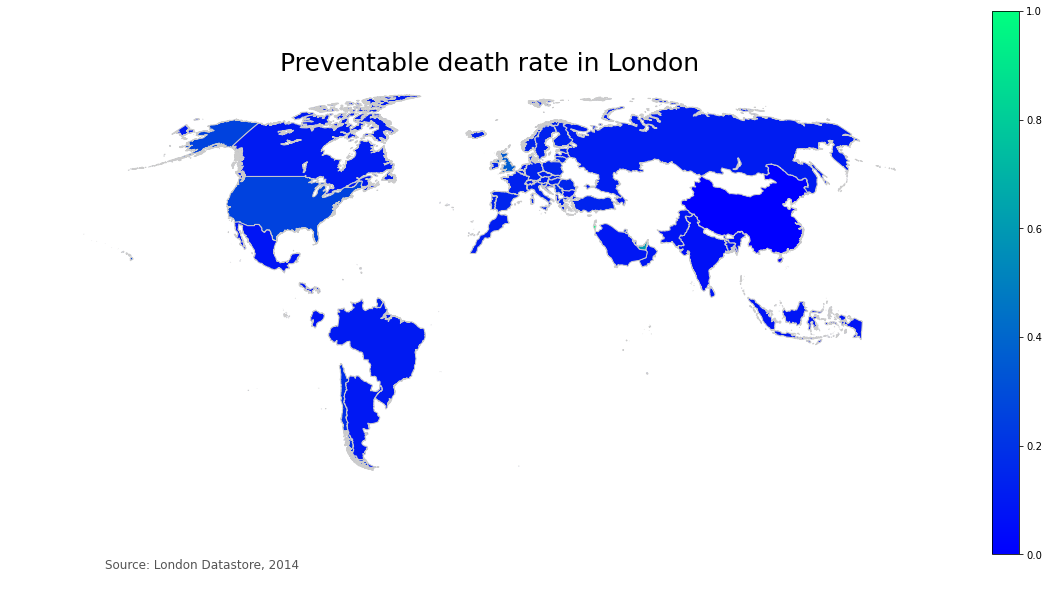

In [22]:
# set a variable that will call whatever column we want to visualise on the map
variable = 'imunization_coverage'
# set the range for the choropleth
vmin, vmax = 0, 1
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(20, 10))
merged.plot(column=variable, cmap='winter', linewidth=1, ax=ax, edgecolor='0.8')
# remove the axis
ax.axis('off')
# add a title
ax.set_title('Preventable death rate in London', fontdict={'fontsize': '25', 'fontweight' : '3'})
# create an annotation for the data source
ax.annotate('Source: London Datastore, 2014',xy=(0.1, .08),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')
# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='winter', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm)